# Fitting pixel grids to flat-field data using weak_sauce

In [1]:
import sys
sys.path.append("/Users/cpd/Projects/weak_sauce/code")

In [4]:
from __future__ import division
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover
from weak_sauce.fit_flat import FlatFitter

from scipy.ndimage.filters import gaussian_filter
from scipy.signal import resample

In this notebook, we demonstrate how our weak_sauce algorithm can be used to:
1. Create a pixel grid with pure E-mode distortions
2. Recover this model from synthesized flat-field data.

These are the main functionalities the casual user will want to understand. For a more detailed demonstration on some "under-the-hood" features of the code, see interactive_documentation.ipynb

## Creating a pixel grid with pure E-mode distortions

### Step 1: Compute the gradient of a scalar field

Text(0.5, 1.0, 'A Random Scalar Field')

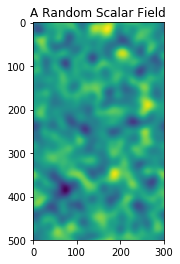

In [5]:
y_size = 500
x_size = 300
data = np.random.normal(size=(y_size,x_size))
smoothed = gaussian_filter(data,sigma=10,mode='wrap')
plt.imshow(smoothed,interpolation='None')
plt.title('A Random Scalar Field')

Compute the gradient:

In [6]:
gradX, gradY = np.gradient(smoothed)
gradX *= 5
gradY *= 5
X, Y = np.meshgrid(np.arange(x_size),np.arange(y_size))

### Step 2: Create a pixel grid model from the computed gradient

Create a rectilinear Source (essentially a pixel grid--we kind of outgrew our initial abstractions...)

In [7]:
source = Source(num_x=y_size,num_y=x_size)

Distort the vertices according to the computed gradients:

In [8]:
source.vertices[:,:,0] += gradX
source.vertices[:,:,1] += gradY

Update the pixel centroids (since we changed the vertex locations):

In [9]:
source.update_centroids()

The default flux level of a "source" is zero, so we need to create an illuminator (default flux level = 1) to compute pixel areas (stored as "fluxes"):

In [10]:
areaFinder = UniformIlluminationMover()

Now we pair the distorted grid and the uniform flux illuminator into a "moveable grid", a pairing that lets us apply the mover to the source.

In [11]:
distorted_grid = MoveableGrid(source,areaFinder)

Now that the mover and source are paired, we can apply the illumination to the pixel grid:

In [12]:
distorted_grid.step()

## Recovering the input pixel grid model from a synthetic flat field

Create a new rectilinear grid as the starting point for the fit:

In [13]:
grid_to_fit = Source(num_x=y_size,num_y=x_size)

Let's save the fluxes from the distorted array we computed in step one. These flat field fluxes will be the target of our fit using the new grid.

In [14]:
distorted_flat_field = distorted_grid.source.fluxes

Instantiate a FlatFitter to fit a pixel grid model to the flat field data. Note that step size, maxiter, etc. may need to be tuned for ideal convergence:

In [15]:
fitter = FlatFitter(grid_to_fit,distorted_flat_field,step_size=0.5)

Finally, run the fitter using the .fit() method. If verbose, the output gives the step number, log-likelihood, and deltas for [x-vertex positions, y-vertex positions, fluxes] at every step.

In [16]:
fitter.fit(maxiter=1000,verbose=True)

0
-0.30247561379292087
[0.04472136 0.05773503 1.        ]
1
-0.2926684284486625
[1.48899926e-01 1.16327210e-01 5.10906648e-05]
2
-0.2834196804271065
[1.42590639e-01 5.70534829e-02 4.38756253e-05]
3
-0.27463208133631295
[3.20638171e-02 2.84312188e-02 4.01015096e-05]
4
-0.26625182277916726
[4.05847395e-02 2.79704345e-02 3.76181590e-05]
5
-0.25824185691063106
[5.31911212e-02 1.14220369e+00 3.57635792e-05]
6
-0.25057364935968757
[6.74123405e-02 5.26807760e-01 3.42664597e-05]
7
-0.24322374671656116
[2.26644236e-02 1.38946288e-02 3.29951102e-05]
8
-0.23617207673750967
[1.38431767e-02 1.75059464e-02 3.18782225e-05]
9
-0.2294010007295643
[1.04308884e-02 2.76520499e-02 3.08735364e-05]
10
-0.22289473652563704
[2.20649850e-02 1.38328857e+00 2.99545685e-05]
11
-0.21663898196671513
[4.58402007e-01 1.18332822e-02 2.91035970e-05]
12
-0.21062065501198443
[1.03480097e-02 1.61926291e-02 2.83084322e-05]
13
-0.20482770583206544
[1.16620147e-02 2.65229294e-02 2.75601922e-05]
14
-0.19924897554457308
[2.7689

## Results show that the output fluxes and vertex positions match the input, as desired

Text(0.5, 1.0, 'Residuals')

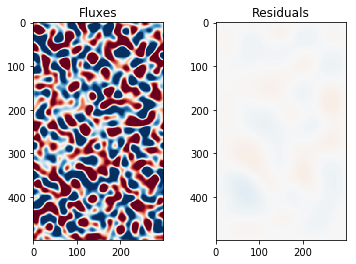

In [19]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(distorted_grid.source.fluxes-1,vmin=-.002,vmax=.002,cmap='RdBu_r')
axs[0].set_title('Fluxes')
axs[1].imshow((grid_to_fit.fluxes-distorted_grid.source.fluxes),vmin=-.002,vmax=.002,cmap='RdBu_r')
axs[1].set_title('Residuals')

Text(0.5, 1.0, 'E-modes; maxiter=1000')

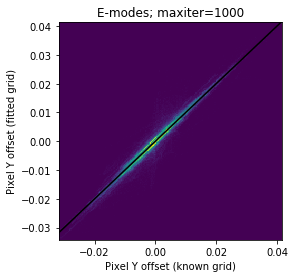

In [20]:
plt.figure(figsize=(4,4))
#create a new rectilinear grid for reference vertex positions
ideal_grid = Source(num_x=y_size,num_y=x_size)
_ = plt.hist2d((grid_to_fit.vertices[:,:,0]-ideal_grid.vertices[:,:,0]).flatten(),
               (distorted_grid.source.vertices[:,:,0]-ideal_grid.vertices[:,:,0]).flatten(),bins=200)
plt.plot([-.12,.12],[-.12,.12],'k')
plt.xlabel('Pixel Y offset (known grid)')
plt.ylabel('Pixel Y offset (fitted grid)')
plt.title('E-modes; maxiter=1000')